In [ ]:
# Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

# Import libraries
import kagglehub
import shutil
import os

# Step 1: Download dataset (will go into Colab's Kaggle cache)
path = kagglehub.dataset_download("prasadshet/indian-sign-language-video-dataset")
print("Dataset cached at:", path)

# Step 2: Copy dataset from cache into Google Drive
src = path
dst = "/content/drive/MyDrive/kaggle_datasets/indian_sign_language"

# Create target directory if not exists
os.makedirs(dst, exist_ok=True)

# Copy files/folders recursivelygrfcedxwq
shutil.copytree(src, dst, dirs_exist_ok=True)

print("✅ Dataset copied to Google Drive at:", dst)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


100%|██████████| 3.23G/3.23G [02:32<00:00, 22.7MB/s]

Extracting files...


Dataset cached at: /root/.cache/kagglehub/datasets/prasadshet/indian-sign-language-video-dataset/versions/1


KeyboardInterrupt: 

In [16]:
import os

# Path to your dataset inside Drive
base_path = "/content/drive/MyDrive/kaggle_datasets/indian_sign_language/Video_Dataset/Video_Dataset/"

# List all folders in the directory
all_folders = [f for f in os.listdir(base_path) if os.path.isdir(os.path.join(base_path, f))]

# Print only the first 3

print("First 3 folders:")
for folder in all_folders[:5]:
    print(folder)


First 3 folders:
Break
Come
Crocodile
Cook
Busy


In [17]:
import os
import random

# Base dataset path
DATA_PATH = "/content/drive/MyDrive/kaggle_datasets/indian_sign_language/Video_Dataset/Video_Dataset/"
# Get all available folders (words)
all_actions = [f for f in os.listdir(DATA_PATH) if os.path.isdir(os.path.join(DATA_PATH, f))]

# Pick any 3 randomly
actions = random.sample(all_actions, 5)

print("🔎 Total available words:", len(all_actions))
print("🎯 Selected words for training:", actions)

# Show number of videos inside each chosen folder
for action in actions:
    folder = os.path.join(DATA_PATH, action)
    print(f"📂 {action} → {len(os.listdir(folder))} videos")


🔎 Total available words: 61
🎯 Selected words for training: ['Good Morning', 'Give', 'Crocodile', 'Maybe', 'Knife']
📂 Good Morning → 60 videos
📂 Give → 60 videos
📂 Crocodile → 60 videos
📂 Maybe → 60 videos
📂 Knife → 60 videos


In [11]:
!pip install mediapipe opencv-python-headless


In [18]:
import cv2
import mediapipe as mp
import numpy as np

mp_holistic = mp.solutions.holistic

# Function to extract keypoints from one frame
def extract_keypoints_from_frame(results):
    pose, lh, rh = [], [], []

    # Pose (33 landmarks × 4 values = 132)
    if results.pose_landmarks:
        for lm in results.pose_landmarks.landmark:
            pose.extend([lm.x, lm.y, lm.z, lm.visibility])
    else:
        pose = [0] * 132

    # Left hand (21 landmarks × 3 values = 63)
    if results.left_hand_landmarks:
        for lm in results.left_hand_landmarks.landmark:
            lh.extend([lm.x, lm.y, lm.z])
    else:
        lh = [0] * 63

    # Right hand (21 landmarks × 3 values = 63)
    if results.right_hand_landmarks:
        for lm in results.right_hand_landmarks.landmark:
            rh.extend([lm.x, lm.y, lm.z])
    else:
        rh = [0] * 63

    return np.array(pose + lh + rh)  # shape = 258


# Function to convert video → sequence of keypoints
def video_to_keypoints(video_path, max_frames=30):
    cap = cv2.VideoCapture(video_path)
    sequence = []

    with mp_holistic.Holistic(min_detection_confidence=0.5,
                              min_tracking_confidence=0.5) as holistic:
        frame_count = 0
        while cap.isOpened():
            ret, frame = cap.read()
            if not ret:
                break
            frame_count += 1

            # Convert BGR → RGB
            image = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            results = holistic.process(image)

            # Extract landmarks
            keypoints = extract_keypoints_from_frame(results)
            sequence.append(keypoints)

            # Stop if we reached max_frames
            if len(sequence) == max_frames:
                break

        cap.release()

    # Pad if sequence shorter
    if len(sequence) < max_frames:
        pad_length = max_frames - len(sequence)
        sequence.extend([np.zeros(sequence[0].shape)] * pad_length)

    print(f"📹 Processed {os.path.basename(video_path)} → {frame_count} frames → sequence shape {np.array(sequence).shape}")
    return np.array(sequence)


In [19]:
# test001

# Picking one sample video from first chosen action
sample_action = actions[0]
sample_video = os.listdir(os.path.join(DATA_PATH, sample_action))[0]
sample_path = os.path.join(DATA_PATH, sample_action, sample_video)

print("🔎 Testing extraction on:", sample_path)
sequence = video_to_keypoints(sample_path)

print("✅ Final sequence shape:", sequence.shape)  # should be (30, 258)


🔎 Testing extraction on: /content/drive/MyDrive/kaggle_datasets/indian_sign_language/Video_Dataset/Video_Dataset/Good Morning/WIN_20231103_13_19_35_Pro.mp4
📹 Processed WIN_20231103_13_19_35_Pro.mp4 → 30 frames → sequence shape (30, 258)
✅ Final sequence shape: (30, 258)


In [20]:
import numpy as np

X, y = [], []

print("📂 Starting dataset creation...\n")
for idx, action in enumerate(actions):
    folder = os.path.join(DATA_PATH, action)
    videos = os.listdir(folder)
    print(f"▶ Processing class: {action} ({len(videos)} videos)")

    for i, video in enumerate(videos):  # ⚠️ for speed, limit to 10 videos first
        video_path = os.path.join(folder, video)
        sequence = video_to_keypoints(video_path)

        X.append(sequence)
        y.append(idx)

        print(f"   ✅ [{i+1}/{len(videos)}] {video} → saved")

print("\n🎯 Dataset creation complete.")
X = np.array(X)
y = np.array(y)

print("🔎 Final shapes:")
print("   X:", X.shape)   # (num_samples, 30, 258)
print("   y:", y.shape)   # (num_samples,)


📂 Starting dataset creation...

▶ Processing class: Good Morning (60 videos)
📹 Processed WIN_20231103_13_19_35_Pro.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [1/60] WIN_20231103_13_19_35_Pro.mp4 → saved
📹 Processed WIN_20231103_13_49_57_Pro_left_tilt.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [2/60] WIN_20231103_13_49_57_Pro_left_tilt.mp4 → saved
📹 Processed WIN_20231103_13_17_37_Pro.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [3/60] WIN_20231103_13_17_37_Pro.mp4 → saved
📹 Processed WIN_20231103_13_18_31_Pro_left_tilt.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [4/60] WIN_20231103_13_18_31_Pro_left_tilt.mp4 → saved
📹 Processed WIN_20231103_13_20_43_Pro_left_tilt.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [5/60] WIN_20231103_13_20_43_Pro_left_tilt.mp4 → saved
📹 Processed WIN_20231103_13_18_31_Pro_right_tilt.mp4 → 30 frames → sequence shape (30, 258)
   ✅ [6/60] WIN_20231103_13_18_31_Pro_right_tilt.mp4 → saved
📹 Processed WIN_20231103_13_17_04_Pro_right_tilt.mp4 → 

In [30]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# One-hot encode labels
y_cat = tf.keras.utils.to_categorical(y, num_classes=len(actions))

print("🔎 Data ready for training:")
print("   X shape:", X.shape)     # (samples, 30, 258)
print("   y shape:", y_cat.shape) # (samples, num_classes)

# Define model
model = Sequential([
    LSTM(64, return_sequences=True, activation='relu', input_shape=(X.shape[1], X.shape[2])),
    LSTM(128, return_sequences=False, activation='relu'),
    Dropout(0.5),
    Dense(64, activation='relu'),
    Dense(len(actions), activation='softmax')
])

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

print("\n📊 Model Summary:")
model.summary()

# Train model
history = model.fit(
    X, y_cat,
    epochs=20,
    batch_size=8,
    validation_split=0.2,
    verbose=1
)

print("\n✅ Training complete!")

model.save("/content/drive/MyDrive/isl_models/isl_sign_model.h5")


🔎 Data ready for training:
   X shape: (300, 30, 258)
   y shape: (300, 5)

📊 Model Summary:


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 30, 64)         │        82,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 128)            │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 190,085 (742.52 KB)

 Trainable params: 190,085 (742.52 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 7s 66ms/step - accuracy: 0.2144 - loss: 1.5883 - val_accuracy: 0.0000e+00 - val_loss: 2.2571
Epoch 2/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 11ms/step - accuracy: 0.2412 - loss: 1.4740 - val_accuracy: 0.0000e+00 - val_loss: 3.5281
Epoch 3/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2850 - loss: 1.4164 - val_accuracy: 0.0000e+00 - val_loss: 4.2330
Epoch 4/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2924 - loss: 1.4056 - val_accuracy: 0.0000e+00 - val_loss: 3.0403
Epoch 5/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.2698 - loss: 1.4231 - val_accuracy: 0.0000e+00 - val_loss: 4.1722
Epoch 6/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3270 - loss: 1.3609 - val_accuracy: 0.0000e+00 - val_loss: 3.2148
Epoch 7/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.3123 - loss: 1.3460 - val_accuracy: 0.0000e+00 - val_loss: 4.5760
Epoch 8/20
30/30 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - accuracy: 0.4277 - loss: 1.2330 - va


✅ Training complete!


In [31]:
# Pick a random video from one of the chosen classes1
import random

test_action = random.choice(actions)
test_video = random.choice(os.listdir(os.path.join(DATA_PATH, test_action)))
test_path = os.path.join(DATA_PATH, test_action, test_video)

print(f"🎥 Testing on: {test_video} (actual label: {test_action})")

# Extract sequence for this video
test_seq = video_to_keypoints(test_path)
test_seq = np.expand_dims(test_seq, axis=0)  # shape (1, 30, 258)

# Make prediction
prediction = model.predict(test_seq)
pred_label = actions[np.argmax(prediction)]

print("🔮 Model prediction:", pred_label)
print("📌 Actual label:", test_action)
print("📊 Prediction probabilities:", prediction)


🎥 Testing on: WIN_20231103_11_02_45_Pro.mp4 (actual label: Give)
📹 Processed WIN_20231103_11_02_45_Pro.mp4 → 30 frames → sequence shape (30, 258)
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
🔮 Model prediction: Good Morning
📌 Actual label: Give
📊 Prediction probabilities: [[4.5544663e-01 3.9418986e-01 3.1451690e-03 1.4721152e-01 6.8118848e-06]]


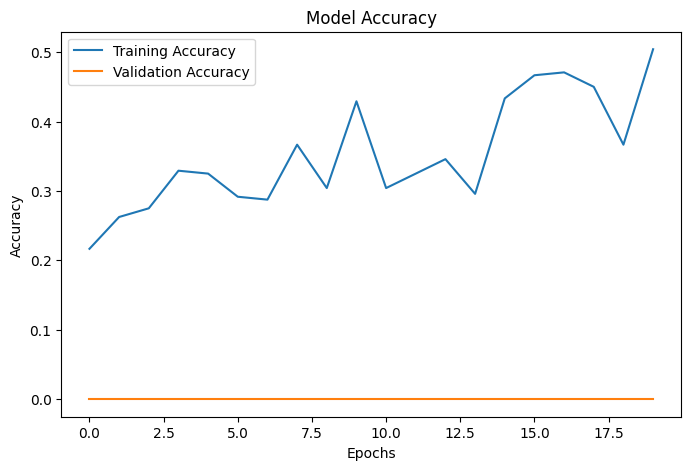

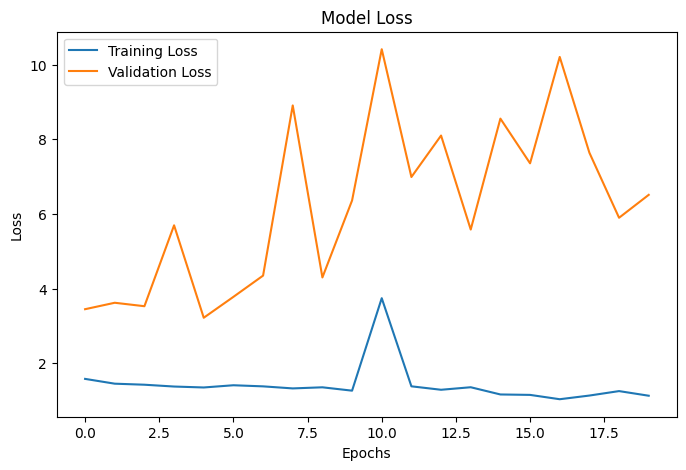

In [29]:
import matplotlib.pyplot as plt

# Plot Accuracy
plt.figure(figsize=(8,5))
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Model Accuracy")
plt.legend()
plt.show()

# Plot Loss
plt.figure(figsize=(8,5))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Model Loss")
plt.legend()
plt.show()
